# v 3.0 xgBoost NO SMOTE

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn import preprocessing
import geopy
from geopy.distance import geodesic
import pickle
from sklearn.ensemble import RandomForestClassifier
import dask.dataframe as dd


In [2]:
import sys
sys.path.append('../references')  # Add the references folder to the system path
model_specs = 'xgBoost NO SMOTE sacle_pos_weight=5'

In [3]:
start_time_notebook = time.time()


In [4]:
# Directory to save the figures 

input_src_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/raw'
output_dir_figures_train = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/train_figures'
output_dir_figures_test = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/test_figures'
#reports_output_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'

reports_output_dir_base = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'
# reports_output_dir for DecisionTrees
reports_output_dir = f"{reports_output_dir_base}/xgBoost"
print(reports_output_dir)

/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/xgBoost


In [5]:
# Define which dataset to use
use_test_data = False  # Set to True when using fraudtest.csv

# Determine dataset type based on the variable
dataset_type = 'Test' if use_test_data else 'Train'
print(dataset_type)

# Load the appropriate dataset

if use_test_data:
    output_dir_figures = output_dir_figures_test
else:
    output_dir_figures = output_dir_figures_train

Train


In [6]:
# Generate the preprocess file name dynamically
# Get the current timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

logfile_title = 'LogFile'
logfile_name = f"{model_specs.replace(',', '')}_{dataset_type}_{logfile_title.replace(',', '').lower().split('.')[0]}_{timestamp}.txt"

logfile_path = os.path.join(reports_output_dir, logfile_name)

# Function to log times to a file
def log_time(step_name, start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    log_message = (f"{step_name} completed at {time.ctime(end_time)}. "
                   f"Elapsed time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds\n")
    
    # Append log to file
    with open(logfile_path, 'a') as f:
        f.write(log_message)
    
    # Print the message to the console as well
    print(log_message)


In [7]:
log_time(f"{model_specs}_{dataset_type} Notebook  started at... ", start_time_notebook)
start_time = time.time()

xgBoost NO SMOTE sacle_pos_weight=5_Train Notebook  started at...  completed at Sun Nov  3 16:05:26 2024. Elapsed time: 0 minutes and 0.03 seconds



In [8]:
from dask.distributed import Client
from sklearn.ensemble import RandomForestClassifier
import dask.dataframe as dd

log_time("Starting the DASK Client", start_time)

# Start Dask client
client = Client()

Starting the DASK Client completed at Sun Nov  3 16:05:26 2024. Elapsed time: 0 minutes and 0.42 seconds



/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56960 instead
  warnings.warn(


In [9]:


# Load the dataset directly into Dask
if use_test_data:
    df_pre = dd.read_csv(f"{input_src_dir}/fraudTest.csv", assume_missing=True)
else:
    df_pre = dd.read_csv(f"{input_src_dir}/fraudTrain.csv", assume_missing=True)


# Now proceed with preprocessing, feature engineering, and model training on `df`


In [10]:
# Optionally repartition the dataset if necessary
df_pre = df_pre.repartition(npartitions=5)


# Strip whitespace from column names and rename
df_pre.columns = df_pre.columns.str.strip()
df_pre = df_pre.rename(columns={'amt': 'TransactionAmount', 'cc_num': 'CreditCardNumber', 'dob': 'DateOfBirth', 'trans_date_trans_time': 'TransactionTime'})

# Repartition to ensure consistency
df_pre = df_pre.repartition(npartitions=5)

# Preview without converting to Pandas
print("Number of partitions:", df_pre.npartitions)
print("Columns:", df_pre.columns)
print(df_pre.head())  # No .compute() here

# Final transformations or computations
# Only use .compute() at the very end if needed, for example:
df = df_pre.compute()  # Converts to Pandas for the entire dataset


Number of partitions: 5
Columns: Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
   Unnamed: 0      TransactionTime  CreditCardNumber  \
0         0.0  2019-01-01 00:00:18      2.703186e+15   
1         1.0  2019-01-01 00:00:44      6.304233e+11   
2         2.0  2019-01-01 00:00:51      3.885949e+13   
3         3.0  2019-01-01 00:01:16      3.534094e+15   
4         4.0  2019-01-01 00:03:06      3.755342e+14   

                             merchant       category  TransactionAmount  \
0          fraud_Rippin, Kub and Mann       misc_net               4.97   
1     fraud_Heller, Gutmann and Zieme    grocery_pos             107.23   
2                fraud_Lind-Buckridge  entertainment             220.11   
3  fra

In [11]:
print(df.columns)
print(df.shape)


Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
(1296675, 23)


In [12]:
# Convert to Pandas and generate TransactionID
df = df_pre.compute()
df = df.reset_index(drop=True)
df['TransactionID'] = df.index + 1  # Unique TransactionID



In [13]:

print("Columns:", df.columns)


Columns: Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID'],
      dtype='object')


In [14]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# no missing values

Missing values per column:
 Unnamed: 0           0
TransactionTime      0
CreditCardNumber     0
merchant             0
category             0
TransactionAmount    0
first                0
last                 0
gender               0
street               0
city                 0
state                0
zip                  0
lat                  0
long                 0
city_pop             0
job                  0
DateOfBirth          0
trans_num            0
unix_time            0
merch_lat            0
merch_long           0
is_fraud             0
TransactionID        0
dtype: int64


In [15]:
# Count of fraud and non-fraud transactions
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)

# Optionally, you can get it in percentage terms
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_percentage)


is_fraud
0.0    1289169
1.0       7506
Name: count, dtype: int64
is_fraud
0.0    99.421135
1.0     0.578865
Name: proportion, dtype: float64


In [16]:
#how many unique credit cards in the data set ??
df['CreditCardNumber'].nunique()

983

In [17]:
print(df.columns)

Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID'],
      dtype='object')


In [18]:
# Convert TransactionTime to datetime
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Optional: Convert DateOfBirth to datetime, if needed
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')

In [19]:
# Set 'TransactionTime' as the index permanently
df.set_index('TransactionTime', inplace=True)

# Verify the index
print(df.index)


DatetimeIndex(['2019-01-01 00:00:18', '2019-01-01 00:00:44',
               '2019-01-01 00:00:51', '2019-01-01 00:01:16',
               '2019-01-01 00:03:06', '2019-01-01 00:04:08',
               '2019-01-01 00:04:42', '2019-01-01 00:05:08',
               '2019-01-01 00:05:18', '2019-01-01 00:06:01',
               ...
               '2020-06-21 12:08:42', '2020-06-21 12:09:22',
               '2020-06-21 12:10:56', '2020-06-21 12:11:23',
               '2020-06-21 12:11:36', '2020-06-21 12:12:08',
               '2020-06-21 12:12:19', '2020-06-21 12:12:32',
               '2020-06-21 12:13:36', '2020-06-21 12:13:37'],
              dtype='datetime64[ns]', name='TransactionTime', length=1296675, freq=None)


In [20]:
# Get the minimum and maximum transaction times from the index
min_time = df.index.min()
max_time = df.index.max()

print(f"Minimum Transaction Time: {min_time}")
print(f"Maximum Transaction Time: {max_time}")


Minimum Transaction Time: 2019-01-01 00:00:18
Maximum Transaction Time: 2020-06-21 12:13:37


In [21]:
df.head()

,Unnamed: 0,CreditCardNumber,merchant,category,TransactionAmount,first,last,gender,street,city,...,long,city_pop,job,DateOfBirth,trans_num,unix_time,merch_lat,merch_long,is_fraud,TransactionID
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,0.0,2.703186e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0,1
2019-01-01 00:00:44,1.0,6.304233e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,2
2019-01-01 00:00:51,2.0,3.885949e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0,3
2019-01-01 00:01:16,3.0,3.534094e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0,4
2019-01-01 00:03:06,4.0,3.755342e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,5


In [22]:
log_time("Initial Steps Completed File Loading, Describe, Date Conversions etc..  ", start_time)
log_time("--------------------------------------------------- ------------------  ", start_time)


Initial Steps Completed File Loading, Describe, Date Conversions etc..   completed at Sun Nov  3 16:05:56 2024. Elapsed time: 0 minutes and 30.04 seconds

--------------------------------------------------- ------------------   completed at Sun Nov  3 16:05:56 2024. Elapsed time: 0 minutes and 30.04 seconds



# Feature Engineering

In [23]:
# Log pre-process time at various steps
start_time = time.time()


In [24]:
log_time("START - Feature Engineering .....  ", start_time)
start_time = time.time()

START - Feature Engineering .....   completed at Sun Nov  3 16:05:56 2024. Elapsed time: 0 minutes and 0.01 seconds



In [25]:

# Clip outliers if necessary
df['TransactionAmount'] = df['TransactionAmount'].clip(upper=df['TransactionAmount'].quantile(0.99))



In [26]:

# Replace inf values with NaN (in case they exist in the 'TransactionAmount' column)
df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/1075701793.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


# next type of VIZ via transaction id vs transaction count


In [27]:
# Extract hour from TransactionTime
df['Hour'] = df.index.hour  # Since TransactionTime is already set as the index


In [28]:
# Calculate fraud rate by hour
fraud_rate_by_hour = df.groupby('Hour')['is_fraud'].mean()

# Sort by fraud rate in descending order
fraud_rate_by_hour = fraud_rate_by_hour.sort_values(ascending=False)

# Define a threshold for high-risk hours (adjust as needed)
threshold = fraud_rate_by_hour.mean()  # Mean fraud rate across all hours

# Dynamically identify high-risk hours based on the threshold
high_risk_hours = fraud_rate_by_hour[fraud_rate_by_hour > threshold].index.tolist()

# Print high-risk hours for reference
print("High-Risk Hours:", high_risk_hours)

# Create the HighRiskHour flag based on dynamically identified high-risk hours
df['HighRiskHour'] = df['Hour'].apply(lambda x: 1 if x in high_risk_hours else 0)

# Print a sample of the DataFrame to verify the new column
print(df[['Hour', 'HighRiskHour']])


High-Risk Hours: [22, 23, 1, 0, 2, 3]
                     Hour  HighRiskHour
TransactionTime                        
2019-01-01 00:00:18     0             1
2019-01-01 00:00:44     0             1
2019-01-01 00:00:51     0             1
2019-01-01 00:01:16     0             1
2019-01-01 00:03:06     0             1
...                   ...           ...
2020-06-21 12:12:08    12             0
2020-06-21 12:12:19    12             0
2020-06-21 12:12:32    12             0
2020-06-21 12:13:36    12             0
2020-06-21 12:13:37    12             0

[1296675 rows x 2 columns]


1. Time-Based Analysis:
Already explored daily and hourly trends in transaction volumes, but now dive deeper into fraud patterns based on time.



In [29]:
#Weekday vs. Weekend: Is fraud more common on weekdays or weekends?
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
fraud_by_day = df[df['is_fraud'] == 1]['DayOfWeek'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayOfWeek'].value_counts().sort_index()



In [30]:

# Define the correct day order
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


df['DayName'] = df.index.day_name()
# Convert the 'DayName' column to a categorical type with the correct order
df['DayName'] = pd.Categorical(df['DayName'], categories=day_order, ordered=True)

fraud_by_day = df[df['is_fraud'] == 1]['DayName'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayName'].value_counts().sort_index()



In [31]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
weekend_fraud = df[df['is_fraud'] == 1]['IsWeekend'].mean()
weekend_non_fraud = df[df['is_fraud'] == 0]['IsWeekend'].mean()

print(f"Percentage of fraud on weekends: {weekend_fraud * 100:.2f}%")
print(f"Percentage of non-fraud on weekends: {weekend_non_fraud * 100:.2f}%")


Percentage of fraud on weekends: 32.55%
Percentage of non-fraud on weekends: 34.84%


In [32]:
log_time("Part1 - TrxAmount, Hour, DayOfWeeek etc..", start_time)
start_time = time.time()


Part1 - TrxAmount, Hour, DayOfWeeek etc.. completed at Sun Nov  3 16:05:58 2024. Elapsed time: 0 minutes and 2.70 seconds



In [33]:
import os
print(os.listdir())  # List all files in the current directory


['.DS_Store', 'v_2.0_RandomForest_Credit_Card_Fraud_Detection.ipynb', 'v_1.2_DecisionTrees_OptFeat_Parallelized_GridSearch_Credit_Card_Fraud_Detection.ipynb', 'v_2.1_RandomForest_Balanced_SMOTE_Credit_Card_Fraud_Detection.ipynb', 'v_2.2_RandomForest_Balanced_SMOTE_GridSearch_Credit_Card_Fraud_Detection.ipynb', 'bkp', 'v_0.0_LogisticRegression_Credit_Card_Fraud_Detection.ipynb', 'v_3.2_xgBoost_Credit_Card_Fraud_Detection.ipynb', '.gitkeep', 'v_3.1_xgBoost_SMOTE_Credit_Card_Fraud_Detection.ipynb', '__pycache__', 'v_0.1_LogisticRegression_Balanced_Credit_Card_Fraud_Detection.ipynb', 'v_1.1_DecisionTrees_Parallelized_GridSearch_Credit_Card_Fraud_Detection.ipynb', '.ipynb_checkpoints', 'v_1.0_DecisionTrees_Credit_Card_Fraud_Detection.ipynb']


# MULTIPROCESSING : distance

In [34]:
import pandas as pd
from geopy.distance import geodesic
import multiprocessing as mp
import numpy as np
import time
import sys
from distance_calculation import calculate_distance_chunk

start_time = time.time()


# Add the current working directory to the system path
sys.path.append(os.getcwd())

# Multiprocessing function to split the dataframe and apply the distance calculation
def parallel_distance_calculation(df, num_partitions=None):
    if num_partitions is None:
        num_partitions = mp.cpu_count()  # Use all available CPU cores
    
    # Split the dataframe into chunks
    df_split = np.array_split(df, num_partitions)
    
    # Create a multiprocessing Pool
    with mp.Pool(num_partitions) as pool:
        # Apply the calculate_distance_chunk function to each chunk in parallel
        result = pool.map(calculate_distance_chunk, df_split)
    
    # Concatenate the results back into a single dataframe
    return pd.concat(result)

# Main block to ensure multiprocessing works correctly
if __name__ == "__main__":
    start_time = time.time()

    # Assuming df has the columns ['lat', 'long', 'merch_lat', 'merch_long']
    
    # Run with limited number of cores (e.g., 4 cores)
    df = parallel_distance_calculation(df, num_partitions=4)  # Use 4 cores instead of all available cores

    # Log the time taken for distance calculation with multiprocessing
    log_time("Part2 - Distance Calculation with Multiprocessing (4 cores)", start_time)

    # Check the first few rows to verify the result
    print(df[['lat', 'long', 'merch_lat', 'merch_long', 'distance']].head())


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Part2 - Distance Calculation with Multiprocessing (4 cores) completed at Sun Nov  3 16:08:07 2024. Elapsed time: 2 minutes and 8.26 seconds

                         lat      long  merch_lat  merch_long    distance
TransactionTime                                                          
2019-01-01 00:00:18  36.0788  -81.1781  36.011293  -82.048315   78.773821
2019-01-01 00:00:44  48.8878 -118.2105  49.159047 -118.186462   30.216618
2019-01-01 00:00:51  42.1808 -112.2620  43.150704 -112.154481  108.102912
2019-01-01 00:01:16  46.2306 -112.1138  47.034331 -112.561071   95.685115
2019-01-01 00:03:06  38.4207  -79.4629  38.674999  -78.632459   77.702395


In [35]:
import os
print(os.getcwd())  # This will print the current working directory


/Users/sadhvichandragiri/Desktop/coding/ZHAW_Project/ML_BigData_Repo_1/notebooks


log_time("Part2 -  Distance Calculation", start_time)
start_time = time.time()


In [36]:
# Check unique values in the 'is_fraud' column
df['is_fraud'].unique()


array([0., 1.])

In [37]:
# Fraud vs Non-Fraud by Merchant Category
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts().head(10)
non_fraud_by_category = df[df['is_fraud'] == 0]['category'].value_counts().head(10)



In [38]:
# Top 5 categories with the highest fraud counts
top_fraud_merchant_categories = df[df['is_fraud'] == 1]['category'].value_counts().head(5).index.tolist()

# Print top fraudulent categories
print("Top Fraudulent Merchant Categories:", top_fraud_merchant_categories)

# Create HighRiskMerchantCategory flag
df['HighRiskMerchantCategory'] = df['category'].apply(lambda x: 1 if x in top_fraud_merchant_categories else 0)



Top Fraudulent Merchant Categories: ['grocery_pos', 'shopping_net', 'misc_net', 'shopping_pos', 'gas_transport']


In [39]:
# Print the count of 1s and 0s in HighRiskMerchantCategory
print(df['HighRiskMerchantCategory'].value_counts())


HighRiskMerchantCategory
0    763876
1    532799
Name: count, dtype: int64


# Potential Additional Features:
Transaction Frequency:
    Feature: How often a credit card has been used within a specific time frame (e.g., last hour or day).
    Why: Fraudsters often make rapid successive transactions within short periods. You could create a rolling window to calculate transaction frequency.
    How: You could calculate the number of transactions within the past X hours/days using a rolling window on the TransactionTime feature.

#age group

In [40]:
import pandas as pd

# Ensure 'DateOfBirth' is in datetime format
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')  # Handle errors during conversion

# Step 1: Calculate Age
# Calculate age in years
df['Age'] = (pd.Timestamp.now() - df['DateOfBirth']).dt.days // 365  # Age in years

# Step 2: Create Age Groups
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Define your age bins, ensuring to cover all possible ages
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']  # Corresponding labels

# Create age group feature, include NaN values handling
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Verify the new features without truncating DataFrame
#print(df[['DateOfBirth', 'Age', 'AgeGroup']].head(10))  # Display the first 10 entries


In [41]:
log_time("Part3 - Merchant Categories & Age group", start_time)
start_time = time.time()


Part3 - Merchant Categories & Age group completed at Sun Nov  3 16:08:08 2024. Elapsed time: 2 minutes and 9.89 seconds



# MULTIPROCESSING : count_transactions_within_last_hour

In [42]:
import pandas as pd
import multiprocessing as mp
import numpy as np
import time
from transaction_frequency import process_chunk  # Import from the .py file

# Multiprocessing function to parallelize the transaction counting
def parallel_count_transactions(df, num_partitions=None):
    if num_partitions is None:
        num_partitions = mp.cpu_count()  # Use all available CPU cores
    
    # Ensure the index is a datetime
    df.index = pd.to_datetime(df.index)
    
    # Split the dataframe into chunks based on the number of partitions (CPU cores)
    df_split = np.array_split(df, num_partitions)
    
    # Create a multiprocessing Pool
    with mp.Pool(num_partitions) as pool:
        # Apply the processing function to each chunk in parallel
        result = pool.map(process_chunk, df_split)
    
    # Combine the results from each chunk into a single series, reset index for consistency
    return pd.concat(result).reset_index(drop=True)

# Assuming df has 'CreditCardNumber' as a column and transaction times are indexed
if __name__ == "__main__":
    start_time = time.time()

    # Apply the parallel processing for transaction frequency counting
    df['TransactionFrequency'] = parallel_count_transactions(df, num_partitions=4)  # Adjust num_partitions as needed

    # Log the time taken for transaction frequency calculation with multiprocessing
    log_time("Part4 - TransactionFrequency Multiprocessing", start_time)

    # Check the first 10 rows
    print(df[['TransactionFrequency']].head(10))


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Part4 - TransactionFrequency Multiprocessing completed at Sun Nov  3 16:12:11 2024. Elapsed time: 4 minutes and 3.07 seconds

                    TransactionFrequency
TransactionTime                         
2019-01-01 00:00:18                  NaN
2019-01-01 00:00:44                  NaN
2019-01-01 00:00:51                  NaN
2019-01-01 00:01:16                  NaN
2019-01-01 00:03:06                  NaN
2019-01-01 00:04:08                  NaN
2019-01-01 00:04:42                  NaN
2019-01-01 00:05:08                  NaN
2019-01-01 00:05:18                  NaN
2019-01-01 00:06:01                  NaN


In [43]:
df.index = pd.to_datetime(df.index)
print(df.index)

DatetimeIndex(['2019-01-01 00:00:18', '2019-01-01 00:00:44',
               '2019-01-01 00:00:51', '2019-01-01 00:01:16',
               '2019-01-01 00:03:06', '2019-01-01 00:04:08',
               '2019-01-01 00:04:42', '2019-01-01 00:05:08',
               '2019-01-01 00:05:18', '2019-01-01 00:06:01',
               ...
               '2020-06-21 12:08:42', '2020-06-21 12:09:22',
               '2020-06-21 12:10:56', '2020-06-21 12:11:23',
               '2020-06-21 12:11:36', '2020-06-21 12:12:08',
               '2020-06-21 12:12:19', '2020-06-21 12:12:32',
               '2020-06-21 12:13:36', '2020-06-21 12:13:37'],
              dtype='datetime64[ns]', name='TransactionTime', length=1296675, freq=None)


In [44]:
# Resample the data to count transactions every hour
transaction_counts_hourly = df.resample('H').size()
transaction_counts_daily = df.resample('D').size()

# Combine with CreditCardNumber if necessary
transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')
print(transaction_counts.head(10))

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/1490275857.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts_hourly = df.resample('H').size()
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/1490275857.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')


   CreditCardNumber     TransactionTime  TransactionCount
0      6.041621e+10 2019-01-01 12:00:00                 1
1      6.041621e+10 2019-01-01 13:00:00                 0
2      6.041621e+10 2019-01-01 14:00:00                 0
3      6.041621e+10 2019-01-01 15:00:00                 0
4      6.041621e+10 2019-01-01 16:00:00                 0
5      6.041621e+10 2019-01-01 17:00:00                 0
6      6.041621e+10 2019-01-01 18:00:00                 0
7      6.041621e+10 2019-01-01 19:00:00                 0
8      6.041621e+10 2019-01-01 20:00:00                 0
9      6.041621e+10 2019-01-01 21:00:00                 0


In [45]:
total_transactions = df.groupby('CreditCardNumber').size().reset_index(name='TotalTransactionCount')
print(total_transactions.head(10))


   CreditCardNumber  TotalTransactionCount
0      6.041621e+10                   1518
1      6.042293e+10                   1531
2      6.042310e+10                    510
3      6.042785e+10                    528
4      6.048700e+10                    496
5      6.049060e+10                   1010
6      6.049559e+10                    518
7      5.018030e+11                   1559
8      5.018181e+11                      8
9      5.018282e+11                    515


In [46]:
# Calculate the time difference between consecutive transactions
time_diff = df.index.to_series().diff().dt.total_seconds()
# Flag rapid transactions (within 5 minutes)
df['RapidTransactionFlag'] = time_diff < 60  # For a 1-minute threshold

# Create a temporary DataFrame for rapid transactions
rapid_transactions = df[df['RapidTransactionFlag']]

# Group by date and count the number of rapid transactions
rapid_transaction_counts = rapid_transactions.groupby(rapid_transactions.index.date).size()
print(rapid_transaction_counts)

# Get a summary of the rapid transactions
rapid_transactions_summary = rapid_transactions.describe()
print(rapid_transactions_summary)


2019-01-01    1960
2019-01-02     606
2019-01-03     701
2019-01-04     952
2019-01-05     879
              ... 
2020-06-17    1327
2020-06-18    1547
2020-06-19    1966
2020-06-20    1910
2020-06-21    1142
Length: 537, dtype: int64
         Unnamed: 0  CreditCardNumber  TransactionAmount           zip  \
count  1.061083e+06      1.061083e+06       1.061083e+06  1.061083e+06   
mean   6.541777e+05      4.168739e+17       6.463842e+01  4.881377e+04   
min    1.000000e+00      6.041621e+10       1.000000e+00  1.257000e+03   
25%    3.399115e+05      1.800429e+14       9.500000e+00  2.623700e+04   
50%    6.543810e+05      3.521417e+15       4.635000e+01  4.817400e+04   
75%    9.639775e+05      4.642255e+15       8.223000e+01  7.204200e+04   
max    1.296674e+06      4.992346e+18       5.459926e+02  9.978300e+04   
std    3.688933e+05      1.308438e+18       8.254229e+01  2.689496e+04   

                lat          long      city_pop  \
count  1.061083e+06  1.061083e+06  1.061083e+06

In [47]:
print(df.columns)


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag'],
      dtype='object')


In [48]:
log_time("Part5 - RapidTransactionFlag", start_time)
start_time = time.time()


Part5 - RapidTransactionFlag completed at Sun Nov  3 16:12:23 2024. Elapsed time: 4 minutes and 14.95 seconds



Transaction Amount Features:
Log Transaction Amount: Normalize the TransactionAmount by taking its logarithm to reduce skewness.
Transaction Amount Flags: Create binary flags for high-value transactions (e.g., if TransactionAmount exceeds a certain threshold).

In [49]:

# Sample DataFrame creation
# Assume 'df' is your DataFrame and has a 'TransactionAmount' column
# df = pd.read_csv('your_data.csv')  # Load your actual data

# Step 1: Log Transaction Amount
# Calculate the log of TransactionAmount
df['LogTransactionAmount'] = np.log1p(df['TransactionAmount'])  # Use log1p for stability with 0 values

# Step 2: Create Transaction Amount Flags
# Define a threshold for high-value transactions
threshold = 100  # Adjust the threshold based on your data context

# Create a flag for high-value transactions
df['HighValueTransactionFlag'] = df['TransactionAmount'] > threshold

# Verify the new features
print(df[['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag']].head(10))  # Display the first 10 entries


                     TransactionAmount  LogTransactionAmount  \
TransactionTime                                                
2019-01-01 00:00:18               4.97              1.786747   
2019-01-01 00:00:44             107.23              4.684259   
2019-01-01 00:00:51             220.11              5.398660   
2019-01-01 00:01:16              45.00              3.828641   
2019-01-01 00:03:06              41.96              3.760269   
2019-01-01 00:04:08              94.63              4.560487   
2019-01-01 00:04:42              44.54              3.818591   
2019-01-01 00:05:08              71.65              4.285653   
2019-01-01 00:05:18               4.27              1.662030   
2019-01-01 00:06:01             198.39              5.295263   

                     HighValueTransactionFlag  
TransactionTime                                
2019-01-01 00:00:18                     False  
2019-01-01 00:00:44                      True  
2019-01-01 00:00:51                    

Behavioral Features:
Count of Transactions in Last X Days: Count how many transactions have occurred in the last 7, 14, or 30 days.
Average Transaction Amount in Last X Days: Calculate the average transaction amount over the same periods.

In [50]:
import pandas as pd

# Assuming 'TransactionTime' is already set as the index and in datetime format

# Step 1: Count of Transactions in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Apply rolling and count the number of transactions for each card
    df[f'TransactionCountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['CreditCardNumber']
        .rolling(f'{days}D')
        .count()
        .reset_index(level=0, drop=True)
    )

# Step 2: Average Transaction Amount in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Calculate the average transaction amount for each credit card in the last X days
    df[f'AverageTransactionAmountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['TransactionAmount']
        .rolling(f'{days}D')
        .mean()
        .reset_index(level=0, drop=True)
    )

# Verify the new features
print(df[['TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
           'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days']].head(10))


                     TransactionCountLast7Days  TransactionCountLast14Days  \
TransactionTime                                                              
2019-01-01 12:47:15                        1.0                         1.0   
2019-01-02 08:44:57                        2.0                         2.0   
2019-01-02 08:47:36                        3.0                         3.0   
2019-01-02 12:38:14                        4.0                         4.0   
2019-01-02 13:10:46                        5.0                         5.0   
2019-01-03 13:56:35                        6.0                         6.0   
2019-01-03 17:05:10                        7.0                         7.0   
2019-01-04 13:59:55                        8.0                         8.0   
2019-01-04 21:17:22                        9.0                         9.0   
2019-01-05 00:42:24                       10.0                        10.0   

                     TransactionCountLast30Days  \
TransactionT

In [51]:
print(df.columns)  # Display all columns in the DataFrame


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days'],
      dtype='object')


In [52]:
log_time("Part6 - TransactionCountLast_X_Days & AverageTrxAmountLast_X_Days", start_time)
start_time = time.time()


Part6 - TransactionCountLast_X_Days & AverageTrxAmountLast_X_Days completed at Sun Nov  3 16:12:37 2024. Elapsed time: 0 minutes and 14.24 seconds



# Graph Construction with NetworkX:

Highlight Fraudulent Nodes: Overlay of fraudulent and non-fraudulent credit cards on this degree distribution to see if there’s a difference in their degrees.

In [53]:


# Create an empty graph
G = nx.Graph()

# Add edges between credit cards and merchants, including transaction amount as an edge attribute
for idx, row in df.iterrows():
    credit_card = str(row['CreditCardNumber'])
    merchant = str(row['merchant'])
    transaction_amount = row['TransactionAmount']  # Ensure TransactionAmount exists in your dataframe
    
    # Add an edge with the transaction amount as an attribute
    G.add_edge(credit_card, merchant, transaction_amount=transaction_amount)


# Calculate degrees for all nodes in the graph
degrees = dict(G.degree())

# Filter degrees for credit cards and merchants
credit_card_nodes = df['CreditCardNumber'].astype(str).unique()
merchant_nodes = df['merchant'].astype(str).unique()

credit_card_degrees = {node: degrees[node] for node in credit_card_nodes if node in degrees}
merchant_degrees = {node: degrees[node] for node in merchant_nodes if node in degrees}

# Debugging: Print counts to ensure correctness
print(f"Number of unique credit card nodes: {len(credit_card_nodes)}")
print(f"Number of unique merchant nodes: {len(merchant_nodes)}")
print(f"Number of credit card nodes with degrees: {len(credit_card_degrees)}")
print(f"Number of merchant nodes with degrees: {len(merchant_degrees)}")

# Create a new DataFrame for easier plotting
degree_df = pd.DataFrame({
    'CreditCardDegree': pd.Series(credit_card_degrees),
    'MerchantDegree': pd.Series(merchant_degrees)
})




Number of unique credit card nodes: 983
Number of unique merchant nodes: 693
Number of credit card nodes with degrees: 983
Number of merchant nodes with degrees: 693


In [54]:
# Add degree information back to the original DataFrame
df['degree'] = df['CreditCardNumber'].astype(str).map(credit_card_degrees)



In [55]:
# Check edges and their attributes
#for edge in G.edges(data=True):
#    print(edge)

#do NOT print this, huge list


In [56]:
df['CreditCardNumber'] = df['CreditCardNumber'].astype(str)


In [57]:
fraud_mapping = df.set_index('CreditCardNumber')['is_fraud'].to_dict()


In [58]:
log_time("Part7 - NetworkX Start Step", start_time)
start_time = time.time()


Part7 - NetworkX Start Step completed at Sun Nov  3 16:14:25 2024. Elapsed time: 1 minutes and 47.59 seconds



# MULTIPROCESSING : betweenness_centrality

In [59]:
import networkx as nx
import time
from networkx_graph_betweeness_centrality import parallel_betweenness_centrality

# Assuming G is your graph
if __name__ == "__main__":
    start_time = time.time()

    # Calculate betweenness centrality using parallel processing
    betweenness_centrality = parallel_betweenness_centrality(G, num_partitions=4)  # Adjust number of cores if needed

    # Log the time taken for betweenness centrality calculation with multiprocessing
    log_time("Part8 - Betweenness Centrality Calculation with Multiprocessing", start_time)

    # Check a few centrality values
    print(list(betweenness_centrality.items())[:10])


Part8 - Betweenness Centrality Calculation with Multiprocessing completed at Sun Nov  3 17:14:20 2024. Elapsed time: 59 minutes and 55.43 seconds

[('60416207185.0', 3.903743365141523e-05), ('fraud_Jones, Sawayn and Romaguera', 0.00016718121427278148), ('fraud_Berge LLC', 0.0003731639453736409), ('fraud_Luettgen PLC', 0.0002880918347168189), ('fraud_Daugherty LLC', 0.00026296051041424566), ('fraud_Beier and Sons', 0.00025675424900787366), ('fraud_Stamm-Witting', 0.00021600459190031658), ('fraud_Conroy-Emard', 0.00021409812196013464), ('fraud_Pollich LLC', 0.00029566515903354184), ('fraud_Monahan-Morar', 0.0002101294467358623)]


In [60]:
df['betweenness_centrality'] = df['CreditCardNumber'].map(betweenness_centrality)


In [61]:
print(df['betweenness_centrality'].describe())
print(df['betweenness_centrality'].isna().sum())  # Check for missing values


count    1.296675e+06
mean     4.163569e-05
std      1.178525e-05
min      2.728628e-09
25%      3.630433e-05
50%      4.399435e-05
75%      5.147284e-05
max      5.736748e-05
Name: betweenness_centrality, dtype: float64
0


In [62]:
# Check betweenness centrality for specific credit card numbers
sample_nodes = ['60416207185', 'fraud_Kutch-Ferry']  # Replace with actual nodes
for node in sample_nodes:
    print(f"{node}: {betweenness_centrality.get(node)}")


60416207185: None
fraud_Kutch-Ferry: 0.00026288184139774875


1. Investigate Nodes with High Betweenness Centrality:

Now that you’ve visualized nodes with high betweenness centrality, you can:

    Examine if fraudulent nodes tend to have high betweenness centrality. This might indicate that these nodes are acting as "connectors" between different parts of the network, which could be a sign of suspicious behavior.
    Compare centrality between fraud and non-fraud nodes to see if there's a pattern.



2. Visualize Communities in the Network:

You could apply community detection to uncover fraud rings or clusters of merchants targeted by fraudsters. The Louvain algorithm is great for this.

In [63]:
import community.community_louvain as community_louvain


# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)



Fraud Node Highlighting:

    Fraudulent nodes (from df['is_fraud'] == 1) are colored red to make them stand out. The rest of the nodes are still colored based on their communities.
    This should help you easily spot any fraudulent nodes in the network.

Top 10 Most Central Nodes:

    We calculate betweenness centrality and extract the top 10 most central nodes.
    These nodes are visualized with their connections, which should help declutter the graph and focus on the key players in the transaction network.

In [64]:

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)

# Create positions for nodes using a spring layout
pos = nx.spring_layout(G)

# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Highlight fraud nodes separately
fraud_nodes = df[df['is_fraud'] == 1]['CreditCardNumber'].values




In [65]:
# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Calculate the percentage of fraud in each community
community_fraud = df.groupby('community')['is_fraud'].mean()



In [66]:

# Print fraud rate per community
print(community_fraud)


community
0    0.008969
1    0.004522
2    0.004426
Name: is_fraud, dtype: float64


In [67]:
community_size = df.groupby('community').size()
print(community_size)


community
0    376297
1    596156
2    324222
dtype: int64


In [68]:
# Combine fraud rates and community sizes into a single DataFrame
fraud_vs_size = pd.concat([community_fraud, df.groupby('community').size()], axis=1)
fraud_vs_size.columns = ['FraudRate', 'CommunitySize']



In [69]:
top_fraud_communities = community_fraud.sort_values(ascending=False).head(5)
print(top_fraud_communities)


community
0    0.008969
1    0.004522
2    0.004426
Name: is_fraud, dtype: float64


In [70]:
# Get the community labels of the top fraud communities
top_community_labels = top_fraud_communities.index.tolist()

# Filter the DataFrame for only the top fraud communities
top_communities_df = df[df['community'].isin(top_community_labels)]


In [71]:
# Show Only the Top Merchants by Fraud Rate:
# Instead of displaying all merchants, you can filter the plot to show only the top 10 or 20 merchants with the highest fraud rates.

# Calculate fraud rate by merchant in the top fraud communities
merchant_fraud_rate = top_communities_df.groupby('merchant')['is_fraud'].mean()

# Sort merchants by fraud rate in descending order
top_merchants = merchant_fraud_rate.sort_values(ascending=False).head(10)

# Print top 10 merchants with highest fraud rate
print(top_merchants)


merchant
fraud_Kozey-Boehm                       0.025723
fraud_Herman, Treutel and Dickens       0.025385
fraud_Kerluke-Abshire                   0.022307
fraud_Brown PLC                         0.022109
fraud_Goyette Inc                       0.021616
fraud_Terry-Huel                        0.021543
fraud_Jast Ltd                          0.021505
fraud_Schmeler, Bashirian and Price     0.020833
fraud_Boyer-Reichert                    0.019916
fraud_Langworth, Boehm and Gulgowski    0.019807
Name: is_fraud, dtype: float64


In [72]:

# Assuming 'category' is a column representing merchant categories
merchantcategory_fraud = top_communities_df.groupby('category')['is_fraud'].mean()

# Sort the fraud rate by merchant category in descending order
merchantcategory_fraud_sorted = merchantcategory_fraud.sort_values(ascending=False)


In [73]:

log_time("Part9 - Community & Top Merchants", start_time)
start_time = time.time()


Part9 - Community & Top Merchants completed at Sun Nov  3 17:15:50 2024. Elapsed time: 61 minutes and 24.70 seconds



In [74]:
# Check the density of the graph (a measure of sparsity)
density = nx.density(G)
print(f"Graph Density: {density}")


Graph Density: 0.34130445623909095


In [75]:
# Calculate and print the average degree
degree_sequence = [degree for node, degree in G.degree()]
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree of Nodes: {average_degree}")


Average Degree of Nodes: 571.6849642004773


In [76]:
log_time("Part10 - Density", start_time)
start_time = time.time()


Part10 - Density completed at Sun Nov  3 17:15:50 2024. Elapsed time: 0 minutes and 0.02 seconds



In [77]:
print(df.columns)

Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'degree',
       'betweenness_centrality', 'community'],
      dtype='object')


In [78]:
selected_features = [
    'TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days',
    'Hour', 'HighRiskHour', 'DayOfWeek', 'IsWeekend', 'TransactionFrequency', 'RapidTransactionFlag',
    'lat', 'long', 'merch_lat', 'merch_long', 'distance', 'city_pop',
    'Age', 'AgeGroup', 'gender', 'state', 'city',
    'degree', 'betweenness_centrality', 'community'
]

df_selected_features = df[selected_features]


# Page rank as new feature

In [79]:
# Calculate PageRank for each node in the graph
pagerank = nx.pagerank(G)

# Map the PageRank values to the 'CreditCardNumber' in the DataFrame
df['pagerank'] = df['CreditCardNumber'].map(pagerank)


In [80]:
# Check for NaN values in the pagerank column
print(df['pagerank'].isna().sum())


0


In [81]:
# Check descriptive statistics of pagerank values
print(df['pagerank'].describe())



count    1.296675e+06
mean     5.971670e-04
std      7.856303e-05
min      9.478567e-05
25%      5.812104e-04
50%      6.195727e-04
75%      6.566711e-04
max      6.834763e-04
Name: pagerank, dtype: float64


In [82]:
# Check how many nodes have a PageRank of zero
zero_pagerank_count = (df['pagerank'] == 0).sum()
print(f"Number of nodes with zero PageRank: {zero_pagerank_count}")


Number of nodes with zero PageRank: 0


In [83]:
# Compare the average PageRank for fraud and non-fraud transactions
fraud_avg_pagerank = df[df['is_fraud'] == 1]['pagerank'].mean()
non_fraud_avg_pagerank = df[df['is_fraud'] == 0]['pagerank'].mean()

print(f"Average PageRank for Fraud: {fraud_avg_pagerank}")
print(f"Average PageRank for Non-Fraud: {non_fraud_avg_pagerank}")


Average PageRank for Fraud: 0.000505843602201983
Average PageRank for Non-Fraud: 0.0005976986758972222


In [84]:
selected_features.append('pagerank')
df_selected_features = df[selected_features]


In [85]:
print(df_selected_features.columns)

Index(['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
       'TransactionCountLast7Days', 'TransactionCountLast14Days',
       'TransactionCountLast30Days', 'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour',
       'DayOfWeek', 'IsWeekend', 'TransactionFrequency',
       'RapidTransactionFlag', 'lat', 'long', 'merch_lat', 'merch_long',
       'distance', 'city_pop', 'Age', 'AgeGroup', 'gender', 'state', 'city',
       'degree', 'betweenness_centrality', 'community', 'pagerank'],
      dtype='object')


In [86]:
print(df.shape)

(1296675, 46)


In [87]:
log_time("Part11 - PageRank", start_time)
start_time = time.time()


Part11 - PageRank completed at Sun Nov  3 17:15:52 2024. Elapsed time: 0 minutes and 2.41 seconds



In [88]:
# Decision Trees start

In [89]:
log_time("END - Feature Engineering .....  ", start_time)
start_time = time.time()
log_time("--------------------------------------------------- ------------------  ", start_time)
start_time = time.time()

END - Feature Engineering .....   completed at Sun Nov  3 17:15:52 2024. Elapsed time: 0 minutes and 0.01 seconds

--------------------------------------------------- ------------------   completed at Sun Nov  3 17:15:52 2024. Elapsed time: 0 minutes and 0.00 seconds



In [90]:
log_time(f"{model_specs}_{dataset_type} START Model ....  ", start_time)
start_time = time.time()

xgBoost NO SMOTE sacle_pos_weight=5_Train START Model ....   completed at Sun Nov  3 17:15:52 2024. Elapsed time: 0 minutes and 0.01 seconds



optimized_features_v2 = [
    'LogTransactionAmount', 'TransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast30Days', 
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 
    'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour', 'IsWeekend', 
    'RapidTransactionFlag', 'lat', 'long', 'merch_lat', 'merch_long', 
    'distance', 'city_pop', 'AgeGroup', 'degree', 'betweenness_centrality', 'pagerank'
]
# First, ensure X contains only the selected features in optimized_features_v2
# df_optimized_features_v2 = df[optimized_features_v2]

# Filter only numerical features
df_optimized_features_v2 = df[optimized_features_v2].select_dtypes(include=['number']).columns
print("Numerical features selected for interactions:", numerical_features)


In [91]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
from itertools import combinations
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Define optimized features
optimized_features_v2 = [
    'LogTransactionAmount', 'TransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast30Days', 
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 
    'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour', 'IsWeekend', 
    'RapidTransactionFlag', 'lat', 'long', 'merch_lat', 'merch_long', 
    'distance', 'city_pop', 'AgeGroup', 'degree', 'betweenness_centrality', 'pagerank'
]

# Load and preprocess data
def load_and_preprocess(df, sample_fraction=1.0):
    # Select only the optimized features
    X = df[optimized_features_v2].sample(frac=sample_fraction)
    y = df['is_fraud'].reset_index(drop=True)
    X = X.reset_index(drop=True)
    
    # Identify and encode categorical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    # Filter numerical features for interaction terms
    numerical_features = X.select_dtypes(include=['number']).columns
    print("Numerical features selected for interactions:", numerical_features)
    
    # Add interaction terms for numerical features only
    for feature1, feature2 in combinations(numerical_features, 2):
        interaction_name = f"{feature1}_x_{feature2}"
        X[interaction_name] = X[feature1] * X[feature2]
    
    return X, y

# Assuming `df` is the DataFrame with your data
X, y = load_and_preprocess(df)  # Prepare the data

# Train XGBoost model
def train_xgboost_without_smote(X, y):
    # Initialize XGBoost with custom scale_pos_weight
    model = XGBClassifier(scale_pos_weight=5, random_state=42)  # Adjust scale_pos_weight as needed
    model.fit(X, y)

    # Evaluate on training data
    y_train_pred = model.predict(X)
    accuracy = accuracy_score(y, y_train_pred)
    clf = classification_report(y, y_train_pred)
    roc_auc = roc_auc_score(y, y_train_pred)
    precision, recall, _ = precision_recall_curve(y, y_train_pred)
    auc_pr = auc(recall, precision)
    
    print("Train Accuracy:", accuracy)
    print("Classification Report (Train):\n", clf)
    print("Train ROC AUC:", roc_auc)
    print("Train Precision-Recall AUC:", auc_pr)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, label="Train Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    return model, accuracy, clf, roc_auc, auc_pr


# Report generation and saving
def generate_and_save_report(model, accuracy, clf, roc_auc, auc_pr, report_dir="reports", file_name="classification_report.txt"):
    report_path = os.path.join(report_dir, file_name)
    
    # Create the report content
    full_report = (
        f"Accuracy: {accuracy:.4f}\n\n"
        f"Classification Report:\n{clf}\n\n"
        f"ROC AUC: {roc_auc:.4f}\n\n"
        f"Precision-Recall AUC: {auc_pr:.4f}"
    )

    # Write the report to a file
    os.makedirs(report_dir, exist_ok=True)
    with open(report_path, 'w') as f:
        f.write(full_report)
    print(f"Report saved to {report_path}")



Numerical features selected for interactions: Index(['LogTransactionAmount', 'TransactionAmount',
       'TransactionCountLast7Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour',
       'IsWeekend', 'lat', 'long', 'merch_lat', 'merch_long', 'distance',
       'city_pop', 'degree', 'betweenness_centrality', 'pagerank'],
      dtype='object')


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [92]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, threshold=0.2):
    # Predict probabilities and apply threshold
    y_test_probs = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_probs >= threshold).astype(int)
    
    # Evaluate accuracy and classification report
    accuracy = accuracy_score(y_test, y_test_pred)
    clf = classification_report(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
    auc_pr = auc(recall, precision)
    
    print("Test Accuracy:", accuracy)
    print("Classification Report (Test):\n", clf)
    print("Test ROC AUC:", roc_auc)
    print("Test Precision-Recall AUC:", auc_pr)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, label="Test Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    return accuracy, clf, roc_auc, auc_pr


Numerical features selected for interactions: Index(['LogTransactionAmount', 'TransactionAmount',
       'TransactionCountLast7Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour',
       'IsWeekend', 'lat', 'long', 'merch_lat', 'merch_long', 'distance',
       'city_pop', 'degree', 'betweenness_centrality', 'pagerank'],
      dtype='object')


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[interaction_name] = X[feature1] * X[feature2]
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_37789/3875116026.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

Train Accuracy: 0.9945391096458249
Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   1289169
         1.0       0.86      0.07      0.13      7506

    accuracy                           0.99   1296675
   macro avg       0.93      0.53      0.56   1296675
weighted avg       0.99      0.99      0.99   1296675

Train ROC AUC: 0.5338074037108652
Train Precision-Recall AUC: 0.4663180690730083


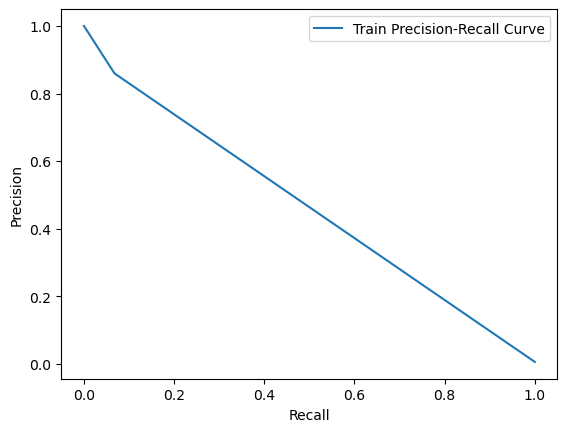

Report saved to /Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/xgBoost/xgBoost NO SMOTE sacle_pos_weight=5_Train_Report_20241103_171555.txt


In [93]:

# Generate a timestamp for the report filename
timestamp = time.strftime("%Y%m%d_%H%M%S")
# Define the report title and output filename
classification_report_title = "Report"
classification_report_filename = f"{model_specs.replace(',', '')}_{dataset_type}_{classification_report_title}_{timestamp}.txt"

# Execute training and evaluation
if use_test_data:
    # Load and preprocess the test data
    X_test, y_test = load_and_preprocess(df)  # Ensure `df` is the test DataFrame
    # Evaluate the model (make sure `evaluate_model` is defined)
    accuracy, clf, roc_auc, auc_pr = evaluate_model(xgb_model_no_smote, X_test, y_test)
    # Generate and save the evaluation report
    generate_and_save_report(xgb_model_no_smote, accuracy, clf, roc_auc, auc_pr, report_dir=reports_output_dir, file_name=classification_report_filename)

else:
    # Assuming `df` is the training DataFrame
    X_train, y_train = load_and_preprocess(df)  # Ensure `df` is the training DataFrame
    # Train the XGBoost model with SMOTE
    xgb_model_no_smote, accuracy, clf, roc_auc, auc_pr = train_xgboost_without_smote(X, y)
    # Generate and save the training report
    generate_and_save_report(xgb_model_no_smote, accuracy, clf, roc_auc, auc_pr, report_dir=reports_output_dir, file_name=classification_report_filename)


In [94]:
log_time(f"{model_specs}_{dataset_type} END Model ....  ", start_time)
start_time = time.time()

xgBoost NO SMOTE sacle_pos_weight=5_Train END Model ....   completed at Sun Nov  3 17:16:54 2024. Elapsed time: 1 minutes and 1.80 seconds



In [95]:

# Close Dask client when done
client.close()
log_time("Closed the DASK Client", start_time)
log_time(".................................................  ", start_time)
start_time = time.time()

Closed the DASK Client completed at Sun Nov  3 17:16:55 2024. Elapsed time: 0 minutes and 0.84 seconds

.................................................   completed at Sun Nov  3 17:16:55 2024. Elapsed time: 0 minutes and 0.84 seconds



In [96]:
import pickle
import os

# Specify the output directory
output_dir_model = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models'
if not os.path.exists(output_dir_model):
    os.makedirs(output_dir_model)  # Ensure the directory exists

# Define model filename
model_outputfilename = f"{model_specs.replace(' ', '_').replace(',', '').lower()}_{dataset_type}.pkl"

if use_test_data:
    print("no need to save model during test phase")
else:
    # Assuming best_rf_model is your final or best model
    try:
        # Save the model
        with open(os.path.join(output_dir_model, model_outputfilename), 'wb') as model_file:
            pickle.dump(xgb_model, model_file)

        print(f"Model saved to {os.path.join(output_dir_model, model_outputfilename)}")

    except NameError:
        print("Error: 'best_rf_model' is not defined. Please ensure the model is assigned before saving.")


Error: 'best_rf_model' is not defined. Please ensure the model is assigned before saving.


In [97]:
import os
import time

# Assuming start_time is defined earlier in the notebook
end_time_notebook = time.time()
elapsed_time = end_time_notebook - start_time_notebook

# Print and format the notebook end time and total execution time
print(f"Notebook ended at: {time.ctime(end_time_notebook)}")
print(f"Total execution time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds")


log_time(f"{model_specs}_{dataset_type} Notebook Ended at... ", start_time_notebook)


Notebook ended at: Sun Nov  3 17:16:55 2024
Total execution time: 71 minutes and 29.36 seconds
xgBoost NO SMOTE sacle_pos_weight=5_Train Notebook Ended at...  completed at Sun Nov  3 17:16:55 2024. Elapsed time: 71 minutes and 29.36 seconds



Use Simpler Models

    Consider testing simpler models like Logistic Regression or Decision Trees, as they may perform better by 
    not overfitting on minority class noise.

